In [1]:
import numpy as np
import pandas as pd
import bokeh.plotting as bp
from bokeh.layouts import gridplot
#bp.output_notebook()
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
%run ../code/PNLEstimatorWrapper.py
%run ../code/EUtilities.py
EU = EUtilities()

In [11]:
#Se lee la señal anteriormente procesada
data_set = pd.read_csv("../data/TrueFX/GBP-USD/GBPUSD-preprocesado-2018-01.csv", parse_dates=True,
                      infer_datetime_format=True, index_col=0)

In [12]:
data_set.head()

,bid,ask
date,,
2018-01-02 00:00:40,1.34979,1.35176
2018-01-02 00:01:00,1.34918,1.35208
2018-01-02 00:01:10,1.34915,1.35354
2018-01-02 00:01:20,1.34915,1.35386
2018-01-02 00:01:30,1.34938,1.35440


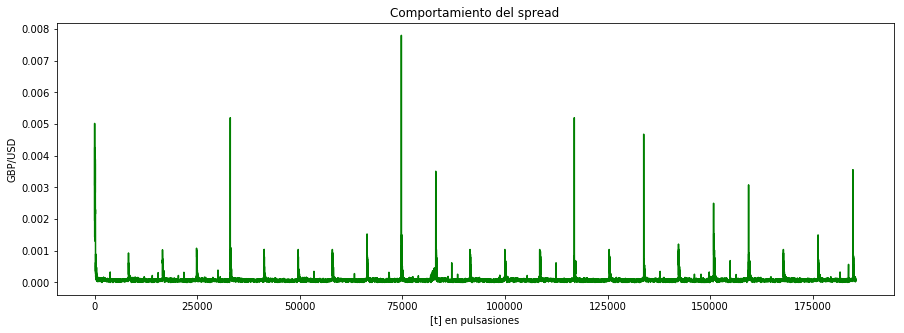

In [13]:
plt.figure(figsize=(15,5))
plt.title('Comportamiento del spread')
plt.xlabel('[t] en pulsasiones')
plt.ylabel('GBP/USD')
plt.plot(np.arange(data_set.shape[0]), data_set.iloc[:,1]-data_set.iloc[:,0], alpha=1, color='green');

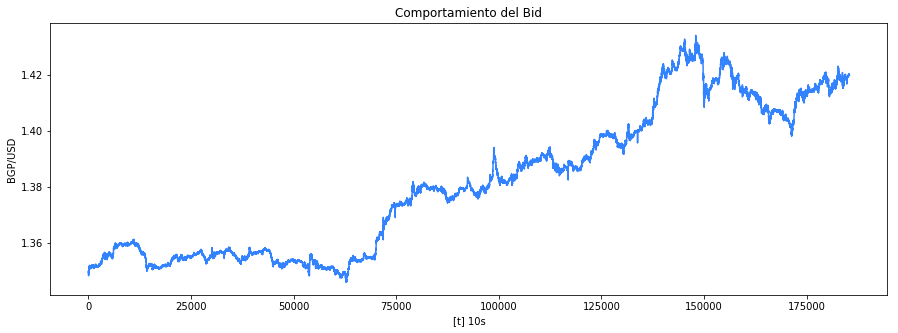

In [14]:
plt.figure(figsize=(15,5))
plt.title('Comportamiento del Bid')
plt.xlabel('[t] 10s')
plt.ylabel('BGP/USD')
plt.plot(np.arange(data_set.shape[0]), data_set.iloc[:,0], alpha=1, color='#3383FF');

#### Construyendo el Dataset
se prueba con la ventana de tamaño 3, con la que dió mejor resultado en EUR/USD, pero se probará tambien con cual tamaño de ventana funciona mejor.

In [15]:
window = 3
X, y_reg, bt = EU.build_dataset(data_set, window, binary_target=True, delete_constant_values=True, PNL=True)

In [16]:
X.shape, y_reg.shape, bt.shape

((160804, 5), (160804,), (160804,))

In [17]:
X.head()

,0,1,2,PNL_0,PNL_1
date,,,,,
2018-01-02 00:01:20,1.34918,1.34915,1.34915,-0.00525,-0.00448
2018-01-02 00:01:40,1.34915,1.34938,1.34938,-0.00362,-0.00444
2018-01-02 00:01:50,1.34938,1.34938,1.34942,-0.00358,-0.00361
2018-01-02 00:02:10,1.34938,1.34942,1.34939,-0.00215,-0.00321
2018-01-02 00:02:40,1.34939,1.34979,1.34979,-0.00321,-0.00213


In [18]:
# se muestrea la señal a predecir por cada hora para colocar con los buy y sell por dia.
signal_sample = (X.resample('1h',loffset='h').last()).iloc[:,2][1:]

Se prueba con un GaussianNB para ver su rendimiento, esto teniendo cuenta que solo es con un mes de datos

In [20]:
from sklearn.naive_bayes import GaussianNB
    
y = bt
n_bdtrain = 4
n_bdtest = 1
mday = 1
#para indexar el dataframe por las fechas
dates = np.unique(X.index.date)[n_bdtrain:]
est_GNB = PNLEstimatorWrapper(GaussianNB(), PNL_column=['PNL_0','PNL_1'])
result_GNB = EU.step_validation(est_GNB, X, y, EU.v_split(X,n_bdtrain,n_bdtest,mday))
result_GNB, predict_GNB = EU.redim(result_GNB)
print('--------- GaussianNB ----------------')
print('average PNL : ', np.mean(result_GNB[:,0]))
print('average buy: ', np.mean(result_GNB[:,1]))
print('average sell: ', np.mean(result_GNB[:,2]))
print('-------------------------------------')
df_GNB = pd.DataFrame(result_GNB, columns=list(['PNL','buys','sells','longest_buys','longest_sells']),index=dates)
print(df_GNB)
df_GNB.to_csv('../resultados/TrueFX/GBP-USD/GaussianNB/pnl_GNB_wsize3_2018-01.csv')

--------- GaussianNB ----------------
average PNL :  -0.571808947368
average buy:  2137.52631579
average sell:  4865.57894737
-------------------------------------
                PNL    buys   sells  longest_buys  longest_sells
2018-01-08 -0.54525   633.0  6166.0         451.0         2635.0
2018-01-09 -0.48016  3585.0  3248.0        2116.0         2825.0
2018-01-10 -0.49300  3864.0  3183.0        1772.0         1066.0
2018-01-11 -0.54816  4759.0  2374.0        4759.0         2374.0
2018-01-12 -0.59333  2545.0  4677.0        2450.0         4643.0
2018-01-15 -0.72842  7279.0     0.0        7279.0            0.0
2018-01-16 -0.60395     0.0  7108.0           0.0         7108.0
2018-01-17 -0.57881     0.0  7515.0           0.0         7515.0
2018-01-18 -0.58522     0.0  7473.0           0.0         7473.0
2018-01-19 -0.62638     0.0  7361.0           0.0         7361.0
2018-01-22 -0.57036     0.0  7399.0           0.0         7399.0
2018-01-23 -0.56589     0.0  7330.0           0.0       

los primeros cuatro días equivalen a 27743 datos del dataset

In [22]:
for i in EU.v_split(X,4,1,1):
    print (i)

(array([    0,     1,     2, ..., 27742, 27743, 27744]), array([27745, 27746, 27747, ..., 34541, 34542, 34543]))
(array([ 6858,  6859,  6860, ..., 34541, 34542, 34543]), array([34544, 34545, 34546, ..., 41374, 41375, 41376]))
(array([13844, 13845, 13846, ..., 41374, 41375, 41376]), array([41377, 41378, 41379, ..., 48421, 48422, 48423]))
(array([20820, 20821, 20822, ..., 48421, 48422, 48423]), array([48424, 48425, 48426, ..., 55554, 55555, 55556]))
(array([27745, 27746, 27747, ..., 55554, 55555, 55556]), array([55557, 55558, 55559, ..., 62776, 62777, 62778]))
(array([34544, 34545, 34546, ..., 62776, 62777, 62778]), array([62779, 62780, 62781, ..., 70055, 70056, 70057]))
(array([41377, 41378, 41379, ..., 70055, 70056, 70057]), array([70058, 70059, 70060, ..., 77163, 77164, 77165]))
(array([48424, 48425, 48426, ..., 77163, 77164, 77165]), array([77166, 77167, 77168, ..., 84678, 84679, 84680]))
(array([55557, 55558, 55559, ..., 84678, 84679, 84680]), array([84681, 84682, 84683, ..., 92151,

In [24]:
firts_4bd = 27745 #primeros 4 días
len(predict_GNB),len(y)- firts_4bd

(133059, 133059)

### Se pintarán las ventas en color rojo y las compras en color verde!

Como para el target se empieza del segundo valor de la fila X, es decir, el primer valor de la señal no tiene una predicción ya que no tiene un valor anterior para ser comparado, por esto se coge la señal "y_reg" y no se toma el último valor ya que este no tiene predicción

In [25]:
#para graficar las compras acertadas sobre la señal original
buy_GNB_ok = ((predict_GNB==bt[firts_4bd:])&(predict_GNB==1))*y_reg[firts_4bd-1:-1]
buy_GNB_ok[buy_GNB_ok==0] = np.nan 
print (buy_GNB_ok.shape)
#para graficar las ventas acertadas sobre la señal original
sell_GNB_ok = ((predict_GNB==bt[firts_4bd:])&(predict_GNB==0))*y_reg[firts_4bd-1:-1]
sell_GNB_ok[sell_GNB_ok==0] = np.nan
print (sell_GNB_ok.shape)

#para graficar las compras fallidas sobre la señal original
buy_GNB_mal = ((predict_GNB!=bt[firts_4bd:])&(predict_GNB==1))*y_reg[firts_4bd-1:-1]
buy_GNB_mal[buy_GNB_mal==0] = np.nan 
print (buy_GNB_mal.shape)
#para graficar las ventas fallidas sobre la señal original
sell_GNB_mal = ((predict_GNB!=bt[firts_4bd:])&(predict_GNB==0))*y_reg[firts_4bd-1:-1]
sell_GNB_mal[sell_GNB_mal==0] = np.nan
print (sell_GNB_mal.shape)

(133059,)
(133059,)
(133059,)
(133059,)


In [26]:
dates = np.unique(data_set.index.date) #para graficar el numero de ventas y compras por dia
x_axis = X.index[firts_4bd:] #para graficar los resultados por datetime

In [27]:
bp.reset_output()

graficando con bokeh

In [29]:
p1_GNB = bp.Figure(width=750, height=300,title='buys and sells with a GaussianNB',x_axis_type='datetime',
               title_location = 'above')
p1_GNB.triangle(x_axis, buy_GNB_ok, color='green', legend='predict buys ok')
p1_GNB.triangle(x_axis, sell_GNB_ok, color='green', legend='predict sells ok', angle=45)
p1_GNB.xaxis.axis_label = 'Datetime'
p1_GNB.yaxis.axis_label = 'GBP/USD'
p1_GNB.triangle(x_axis, buy_GNB_mal, color='red', legend='predict incorrect buy')
p1_GNB.triangle(x_axis, sell_GNB_mal, color='red', legend='predict incorrect sell', angle=45)
p1_GNB.line(x_axis, y_reg[firts_4bd-1:-1], color='blue', alpha=0.2, legend='bid')
p1_GNB.legend.location = 'bottom_left'
p1_GNB.legend.orientation = 'horizontal'
p1_GNB.legend.background_fill_color = 'grey'
p1_GNB.legend.background_fill_alpha = 0.1
p1_GNB.legend.border_line_alpha = None

p2_GNB = bp.Figure(width=750, height=300,title='Profit and Loss with a GaussianNB',x_axis_type='datetime')
p2_GNB.line(dates[n_bdtrain:], result_GNB[:,0], color='blue', legend='PNL', alpha=0.5)
p2_GNB.circle(dates[n_bdtrain:], result_GNB[:,0], color='blue', legend='PNL', alpha=0.5)
p2_GNB.line(dates[n_bdtrain:], np.zeros(len(result_GNB)), color='red', legend='PNL = 0', line_dash='dotted')
p2_GNB.line(dates[n_bdtrain:],np.ones(len(result_GNB[:,0]))*np.mean(result_GNB[:,0]),color='green',legend='avg PNL')
p2_GNB.xaxis.axis_label = 'datetime'
p2_GNB.yaxis.axis_label = 'PNL'
p2_GNB.legend.location ='bottom_center'
p2_GNB.legend.orientation = 'horizontal'

p3_GNB = bp.Figure(width=400, height=250, title='buys per day', x_axis_type='datetime')
p3_GNB.line(dates[n_bdtrain:], result_GNB[:,1], color='green')
p3_GNB.circle(dates[n_bdtrain:], result_GNB[:,1], color='green')
p3_GNB.xaxis.axis_label = 'datetime'
p3_GNB.yaxis.axis_label = 'buys per day'
#se utiliza el x_range para correlacionar las dos gráficas por el eje x
p4_GNB = bp.Figure(width=400, height=250, title='sells per day', x_axis_type='datetime',x_range=p3_GNB.x_range)
p4_GNB.line(dates[n_bdtrain:], result_GNB[:,2], color='red')
p4_GNB.circle(dates[n_bdtrain:], result_GNB[:,2], color='red')
p4_GNB.xaxis.axis_label = 'datetime'
p4_GNB.yaxis.axis_label = 'sells per day'

#para pintar el PNL que se va acumulando
PNL_accu_GNB = []
count_GNB = 0
for i in result_GNB[:,0]:
    count_GNB += i
    PNL_accu_GNB.append(count_GNB)
#se pinta el PNL acumulado
p5_GNB = bp.Figure(width=750, height=300,title='PNL accumulated with a GaussianNB',x_axis_type='datetime',
                   x_range=p2_GNB.x_range)
p5_GNB.line(dates[n_bdtrain:],PNL_accu_GNB,color='blue',legend='PNL accumulated',alpha=0.5)
p5_GNB.circle(dates[n_bdtrain:], PNL_accu_GNB, color='blue',legend='PNL accumulated', alpha=0.5)
p5_GNB.line(dates[n_bdtrain:], np.zeros(len(result_GNB)), color='red', legend='PNL = 0', line_dash='dotted')
p5_GNB.xaxis.axis_label = 'datetime'
p5_GNB.yaxis.axis_label = 'PNL accumulated'
p5_GNB.legend.location ='bottom_center'
p5_GNB.legend.orientation = 'horizontal'

#se pinta la señal submuestreada para verlas con en volumen de compras y ventas por día
p6_GNB = bp.Figure(width=400, height=250, title='signal per hours', x_axis_type='datetime',x_range=p3_GNB.x_range)
p6_GNB.line(signal_sample.index, signal_sample, color='blue')
p6_GNB.xaxis.axis_label = 'datetime'
p6_GNB.yaxis.axis_label = 'bid GBP/USD'

bp.show(gridplot([[p1_GNB,p3_GNB],[p2_GNB,p4_GNB],[p5_GNB,p6_GNB]], toolbar_location="right"))
bp.output_file(filename='../resultados/TrueFX/GBP-USD/GaussianNB/grafico GaussianNB.html', title='GaussianNB')

### Se prueba con un KNeighborsClassifier

In [31]:
from sklearn.neighbors import KNeighborsClassifier

est_KNC = PNLEstimatorWrapper(KNeighborsClassifier(n_neighbors=7,n_jobs=2,leaf_size=30
                                                   ,algorithm='kd_tree'), PNL_column=['PNL_0','PNL_1'])
result_KNC = EU.step_validation(est_KNC, X, y, EU.v_split(X,4,1,1))
result_KNC, predict_KNC = EU.redim(result_KNC)
print('-------- KNeighborsClassifier -------')
print('average PNL: ', np.mean(result_KNC[:,0]))
print('average buy: ', np.mean(result_KNC[:,1]))
print('average sell: ', np.mean(result_KNC[:,2]))
print('-------------------------------------')
df_KNC = pd.DataFrame(result_KNC, columns=list(['PNL','buys','sells','longest_buys','longest_sells']),index=dates)
print(df_KNC)
df_KNC.to_csv('../resultados/TrueFX/GBP-USD/KNeighborsClassifier/pnl_KNC_wsize3_2018-01.csv')

-------- KNeighborsClassifier -------
average PNL:  -0.572001578947
average buy:  2630.42105263
average sell:  4372.68421053
-------------------------------------


ValueError: Shape of passed values is (5, 19), indices imply (5, 23)

graficando con bokeh los resultados

In [21]:
#para graficar las compras acertadas sobre la señal original
buy_KNC_ok = ((predict_KNC==bt[firts_4bd:])&(predict_KNC==1))*y_reg[firts_4bd-1:-1]
buy_KNC_ok[buy_KNC_ok==0] = np.nan 
print (buy_KNC_ok.shape)
#para graficar las ventas acertadas sobre la señal original
sell_KNC_ok = ((predict_KNC==bt[firts_4bd:])&(predict_KNC==0))*y_reg[firts_4bd-1:-1]
sell_KNC_ok[sell_KNC_ok==0] = np.nan
print (sell_KNC_ok.shape)

#para graficar las compras fallidas sobre la señal original
buy_KNC_mal = ((predict_KNC!=bt[firts_4bd:])&(predict_KNC==1))*y_reg[firts_4bd-1:-1]
buy_KNC_mal[buy_KNC_mal==0] = np.nan 
print (buy_KNC_mal.shape)
#para graficar las ventas fallidas sobre la señal original
sell_KNC_mal = ((predict_KNC!=bt[firts_4bd:])&(predict_KNC==0))*y_reg[firts_4bd-1:-1]
sell_KNC_mal[sell_KNC_mal==0] = np.nan
print (sell_KNC_mal.shape)

(133061,)
(133061,)
(133061,)
(133061,)


In [22]:
bp.reset_output()

In [24]:
p1_KNC = bp.Figure(width=750, height=300,title='buys and sells with a KNeighborsClassifier',x_axis_type='datetime',
               title_location = 'above')
p1_KNC.triangle(x_axis, buy_KNC_ok, color='green', legend='predict buys ok')
p1_KNC.triangle(x_axis, sell_KNC_ok, color='green', legend='predict sells ok', angle=45)
p1_KNC.xaxis.axis_label = 'Datetime'
p1_KNC.yaxis.axis_label = 'GBP/USD'
p1_KNC.triangle(x_axis, buy_KNC_mal, color='red', legend='predict incorrect buy')
p1_KNC.triangle(x_axis, sell_KNC_mal, color='red', legend='predict incorrect sell', angle=45)
p1_KNC.line(x_axis, y_reg[firts_4bd-1:-1], color='blue', alpha=0.2, legend='bid')
p1_KNC.legend.location = 'bottom_left'
p1_KNC.legend.orientation = 'horizontal'
p1_KNC.legend.background_fill_color = 'grey'
p1_KNC.legend.background_fill_alpha = 0.1
p1_KNC.legend.border_line_alpha = None

p2_KNC = bp.Figure(width=750, height=300,title='Profit and Loss with a KNeighborsClassifier',x_axis_type='datetime')
p2_KNC.line(dates[n_bdtrain:], result_KNC[:,0], color='blue', legend='PNL', alpha=0.5)
p2_KNC.circle(dates[n_bdtrain:], result_KNC[:,0], color='blue', legend='PNL', alpha=0.5)
p2_KNC.line(dates[n_bdtrain:], np.zeros(len(result_KNC)), color='red', legend='PNL = 0', line_dash='dotted')
p2_KNC.line(dates[n_bdtrain:],np.ones(len(result_KNC[:,0]))*np.mean(result_KNC[:,0]),color='green',legend='avg PNL')
p2_KNC.xaxis.axis_label = 'datetime'
p2_KNC.yaxis.axis_label = 'PNL'
p2_KNC.legend.location ='bottom_center'
p2_KNC.legend.orientation = 'horizontal'

p3_KNC = bp.Figure(width=400, height=250, title='buys per day', x_axis_type='datetime')
p3_KNC.line(dates[n_bdtrain:], result_KNC[:,1], color='green')
p3_KNC.circle(dates[n_bdtrain:], result_KNC[:,1], color='green')
p3_KNC.xaxis.axis_label = 'datetime'
p3_KNC.yaxis.axis_label = 'buys per day'
#se utiliza el x_range para correlacionar las dos gráficas por el eje x
p4_KNC = bp.Figure(width=400, height=250, title='sells per day', x_axis_type='datetime',x_range=p3_KNC.x_range)
p4_KNC.line(dates[n_bdtrain:], result_KNC[:,2], color='red')
p4_KNC.circle(dates[n_bdtrain:], result_KNC[:,2], color='red')
p4_KNC.xaxis.axis_label = 'datetime'
p4_KNC.yaxis.axis_label = 'sells per day'

#para pintar el PNL que se va acumulando
PNL_accu_KNC = []
count_KNC = 0
for i in result_KNC[:,0]:
    count_KNC += i
    PNL_accu_KNC.append(count_KNC)
    
p5_KNC = bp.Figure(width=750, height=300,title='PNL accumulated with a KNeighborsClassifier',x_axis_type='datetime',
                   x_range=p2_KNC.x_range)
p5_KNC.line(dates[n_bdtrain:],PNL_accu_KNC,color='blue',legend='PNL accumulated',alpha=0.5)
p5_KNC.circle(dates[n_bdtrain:], PNL_accu_KNC, color='blue',legend='PNL accumulated', alpha=0.5)
p5_KNC.line(dates[n_bdtrain:], np.zeros(len(result_KNC)), color='red', legend='PNL = 0', line_dash='dotted')
p5_KNC.xaxis.axis_label = 'datetime'
p5_KNC.yaxis.axis_label = 'PNL accumulated'
p5_KNC.legend.location ='bottom_center'
p5_KNC.legend.orientation = 'horizontal'
#se pinta la señal submuestreada para verlas con en volumen de compras y ventas por día
p6_KNC = bp.Figure(width=400, height=250, title='signal per hours', x_axis_type='datetime',x_range=p3_KNC.x_range)
p6_KNC.line(signal_sample.index, signal_sample, color='blue')
p6_KNC.xaxis.axis_label = 'datetime'
p6_KNC.yaxis.axis_label = 'bid GBP/USD'

bp.show(gridplot([[p1_KNC,p3_KNC],[p2_KNC,p4_KNC],[p5_KNC,p6_KNC]], toolbar_location="right"))
bp.output_file(filename='grafico KNeihgborsClassifier.html', title='KNeihgborsClassifier')

### se prueba con un DecisionTreeClassifier

In [20]:
from sklearn.tree import DecisionTreeClassifier

est_DTC = PNLEstimatorWrapper(DecisionTreeClassifier(), PNL_column='PNL')
result_DTC = step_validation(est_DTC, X, y, v_split(X,4,1,1))
result_DTC, predict_DTC = redim(result_DTC)
print('------ DecisionTreeClassifier -------')
print('average PNL: ', np.mean(result_DTC[:,0]))
print('average buy: ', np.mean(result_DTC[:,1]))
print('average sell: ', np.mean(result_DTC[:,2]))
print('-------------------------------------')
df_DTC = pd.DataFrame(result_DTC, columns=list(['PNL','buys','sells','longest_buys','longest_sells']),index=dates)
print(df_DTC)
df_DTC.to_csv('../resultados/TrueFX/GBP-USD/DecisionTreeClassifier/pnl_DTC_wsize3_2018-01.csv')

------ DecisionTreeClassifier -------
average PNL:  0.00383789473684
average buy:  2967.47368421
average sell:  4035.73684211
-------------------------------------
                PNL    buys   sells  longest_buys  longest_sells
2018-01-08  0.01786  3131.0  3668.0          11.0           17.0
2018-01-09  0.00852  3250.0  3583.0          16.0           18.0
2018-01-10  0.00516  3449.0  3599.0         274.0           11.0
2018-01-11 -0.00270  2851.0  4282.0          20.0          453.0
2018-01-12 -0.01391  1443.0  5778.0          11.0         4112.0
2018-01-15  0.00530   907.0  6373.0          13.0         4020.0
2018-01-16  0.00652  3408.0  3699.0          13.0           45.0
2018-01-17 -0.00059  2507.0  5008.0           9.0         1945.0
2018-01-18 -0.00212  3506.0  3967.0          37.0           28.0
2018-01-19  0.00119  3072.0  4289.0          14.0          109.0
2018-01-22 -0.00012  2598.0  4801.0          15.0         1338.0
2018-01-23  0.01494  2842.0  4488.0          30.0       

In [26]:
#para graficar las compras acertadas sobre la señal original
buy_DTC_ok = ((predict_DTC==bt[firts_4bd:])&(predict_DTC==1))*y_reg[firts_4bd-1:-1]
buy_DTC_ok[buy_DTC_ok==0] = np.nan 
print (buy_DTC_ok.shape)
#para graficar las ventas acertadas sobre la señal original
sell_DTC_ok = ((predict_DTC==bt[firts_4bd:])&(predict_DTC==0))*y_reg[firts_4bd-1:-1]
sell_DTC_ok[sell_DTC_ok==0] = np.nan
print (sell_DTC_ok.shape)

#para graficar las compras fallidas sobre la señal original
buy_DTC_mal = ((predict_DTC!=bt[firts_4bd:])&(predict_DTC==1))*y_reg[firts_4bd-1:-1]
buy_DTC_mal[buy_DTC_mal==0] = np.nan 
print (buy_DTC_mal.shape)
#para graficar las ventas fallidas sobre la señal original
sell_DTC_mal = ((predict_DTC!=bt[firts_4bd:])&(predict_DTC==0))*y_reg[firts_4bd-1:-1]
sell_DTC_mal[sell_DTC_mal==0] = np.nan
print (sell_DTC_mal.shape)

(133061,)
(133061,)
(133061,)
(133061,)


In [27]:
bp.reset_output()

In [29]:
p1_DTC = bp.figure(width=750, height=300,title='buys and sells with a DecisionTreeClassifier',x_axis_type='datetime',
               title_location = 'above')
p1_DTC.triangle(x_axis, buy_DTC_ok, color='green', legend='predict buys ok')
p1_DTC.triangle(x_axis, sell_DTC_ok, color='green', legend='predict sells ok', angle=45)
p1_DTC.xaxis.axis_label = 'Datetime'
p1_DTC.yaxis.axis_label = 'GBP/USD'
p1_DTC.triangle(x_axis, buy_DTC_mal, color='red', legend='predict incorrect buy')
p1_DTC.triangle(x_axis, sell_DTC_mal, color='red', legend='predict incorrect sell', angle=45)
p1_DTC.line(x_axis, y_reg[firts_4bd-1:-1], color='blue', alpha=0.2, legend='bid')
p1_DTC.legend.location = 'bottom_left'
p1_DTC.legend.orientation = 'horizontal'
p1_DTC.legend.background_fill_color = 'grey'
p1_DTC.legend.background_fill_alpha = 0.1
p1_DTC.legend.border_line_alpha = None

p2_DTC = bp.figure(width=750, height=300,title='Profit and Loss with a DecisionTreeClassifier'
                   ,x_axis_type='datetime')
p2_DTC.line(dates[n_bdtrain:], result_DTC[:,0], color='blue', legend='PNL', alpha=0.5)
p2_DTC.circle(dates[n_bdtrain:], result_DTC[:,0], color='blue', legend='PNL', alpha=0.5)
p2_DTC.line(dates[n_bdtrain:], np.zeros(len(result_DTC)), color='red', legend='PNL = 0', line_dash='dotted')
p2_DTC.line(dates[n_bdtrain:],np.ones(len(result_DTC[:,0]))*np.mean(result_DTC[:,0]),color='green',legend='avg PNL')
p2_DTC.xaxis.axis_label = 'datetime'
p2_DTC.yaxis.axis_label = 'PNL'
p2_DTC.legend.location ='bottom_center'
p2_DTC.legend.orientation = 'horizontal'

p3_DTC = bp.figure(width=400, height=250, title='buys per day', x_axis_type='datetime')
p3_DTC.line(dates[n_bdtrain:], result_DTC[:,1], color='green')
p3_DTC.circle(dates[n_bdtrain:], result_DTC[:,1], color='green')
p3_DTC.xaxis.axis_label = 'datetime'
p3_DTC.yaxis.axis_label = 'buys per day'
#se utiliza el x_range para correlacionar las dos gráficas por el eje x
p4_DTC = bp.figure(width=400, height=250, title='sells per day', x_axis_type='datetime',x_range=p3_DTC.x_range)
p4_DTC.line(dates[n_bdtrain:], result_DTC[:,2], color='red')
p4_DTC.circle(dates[n_bdtrain:], result_DTC[:,2], color='red')
p4_DTC.xaxis.axis_label = 'datetime'
p4_DTC.yaxis.axis_label = 'sells per day'

#para pintar el PNL que se va acumulando
PNL_accu_DTC = []
count_DTC = 0
for i in result_DTC[:,0]:
    count_DTC += i
    PNL_accu_DTC.append(count_DTC)
    
p5_DTC = bp.figure(width=750, height=300,title='PNL accumulated with a DecisionTreeClassifier',
                   x_axis_type='datetime',x_range=p2_DTC.x_range)
p5_DTC.line(dates[n_bdtrain:],PNL_accu_DTC,color='blue',legend='PNL accumulated',alpha=0.5)
p5_DTC.circle(dates[n_bdtrain:], PNL_accu_DTC, color='blue',legend='PNL accumulated', alpha=0.5)
p5_DTC.line(dates[n_bdtrain:], np.zeros(len(result_DTC)), color='red', legend='PNL = 0', line_dash='dotted')
p5_DTC.xaxis.axis_label = 'datetime'
p5_DTC.yaxis.axis_label = 'PNL accumulated'
p5_DTC.legend.location ='bottom_center'
p5_DTC.legend.orientation = 'horizontal'
#se pinta la señal submuestreada para verlas con en volumen de compras y ventas por día
p6_DTC = bp.figure(width=400, height=250, title='signal per hours', x_axis_type='datetime',x_range=p3_DTC.x_range)
p6_DTC.line(signal_sample.index, signal_sample, color='blue')
p6_DTC.xaxis.axis_label = 'datetime'
p6_DTC.yaxis.axis_label = 'bid GBP/USD'

bp.show(gridplot([[p1_DTC,p3_DTC],[p2_DTC,p4_DTC],[p5_DTC,p6_DTC]], toolbar_location="right"))
bp.output_file(filename='grafico DecisionTreeClassifier.html', title='DecisionTreeClassifier')

### probando con un RandomForestClassifier, con ciertos parametros establecidos los cuales me han arrojado mejores resultados

In [21]:
from sklearn.ensemble import RandomForestClassifier

est_RFC = PNLEstimatorWrapper(RandomForestClassifier(n_estimators=15, n_jobs=3), PNL_column='PNL')
result_RFC = step_validation(est_RFC, X, y, v_split(X,4,1,1))
result_RFC, predict_RFC = redim(result_RFC)
print('RandomForestClassifier')
print('PNL promedio: ', np.mean(result_RFC[:,0]))
print('buy promedio: ', np.mean(result_RFC[:,1]))
print('sell promedio: ', np.mean(result_RFC[:,2]))
print('-------------------------------------')
df_RFC = pd.DataFrame(result_RFC, columns=list(['PNL','buys','sells','longest_buys','longest_sells']),index=dates)
print(df_RFC)
df_RFC.to_csv('../resultados/TrueFX/GBP-USD/RandomForestClassifier/pnl_RFC_wsize3_2018-01.csv')

RandomForestClassifier
PNL promedio:  0.00166947368421
buy promedio:  2635.47368421
sell promedio:  4367.73684211
-------------------------------------
                     PNL    buys   sells  longest_buys  longest_sells
2018-01-08  9.920000e-03  3114.0  3685.0          10.0           13.0
2018-01-09  3.800000e-03  3185.0  3648.0          11.0           19.0
2018-01-10  3.120000e-03  3486.0  3562.0         274.0           12.0
2018-01-11 -3.480000e-03  3162.0  3971.0          30.0          453.0
2018-01-12 -9.590000e-03  1406.0  5815.0          10.0         4112.0
2018-01-15 -1.200000e-04   748.0  6532.0          10.0         4020.0
2018-01-16 -1.576517e-14  3378.0  3729.0          17.0           23.0
2018-01-17 -5.230000e-03  2456.0  5059.0          12.0         1952.0
2018-01-18  8.980000e-03  3406.0  4067.0          36.0           38.0
2018-01-19  1.501000e-02  2816.0  4545.0          30.0          362.0
2018-01-22  2.740000e-03  2564.0  4835.0          10.0         1338.0
2018-01-

In [31]:
#para graficar las compras acertadas sobre la señal original
buy_RFC_ok = ((predict_RFC==bt[firts_4bd:])&(predict_RFC==1))*y_reg[firts_4bd-1:-1]
buy_RFC_ok[buy_RFC_ok==0] = np.nan 
print (buy_RFC_ok.shape)
#para graficar las ventas acertadas sobre la señal original
sell_RFC_ok = ((predict_RFC==bt[firts_4bd:])&(predict_RFC==0))*y_reg[firts_4bd-1:-1]
sell_RFC_ok[sell_RFC_ok==0] = np.nan
print (sell_RFC_ok.shape)

#para graficar las compras fallidas sobre la señal original
buy_RFC_mal = ((predict_RFC!=bt[firts_4bd:])&(predict_RFC==1))*y_reg[firts_4bd-1:-1]
buy_RFC_mal[buy_RFC_mal==0] = np.nan 
print (buy_RFC_mal.shape)
#para graficar las ventas fallidas sobre la señal original
sell_RFC_mal = ((predict_RFC!=bt[firts_4bd:])&(predict_RFC==0))*y_reg[firts_4bd-1:-1]
sell_RFC_mal[sell_RFC_mal==0] = np.nan
print (sell_RFC_mal.shape)

(133061,)
(133061,)
(133061,)
(133061,)


In [32]:
bp.reset_output()

In [34]:
p1_RFC = bp.figure(width=750, height=300,title='buys and sells with a RandomForestClassifier',x_axis_type='datetime',
               title_location = 'above')
p1_RFC.triangle(x_axis, buy_RFC_ok, color='green', legend='predict buys ok')
p1_RFC.triangle(x_axis, sell_RFC_ok, color='green', legend='predict sells ok', angle=45)
p1_RFC.xaxis.axis_label = 'Datetime'
p1_RFC.yaxis.axis_label = 'GBP/USD'
p1_RFC.triangle(x_axis, buy_RFC_mal, color='red', legend='predict incorrect buy')
p1_RFC.triangle(x_axis, sell_RFC_mal, color='red', legend='predict incorrect sells', angle=45)
p1_RFC.line(x_axis, y_reg[firts_4bd-1:-1], color='blue', alpha=0.2, legend='bid')
p1_RFC.legend.location = 'bottom_left'
p1_RFC.legend.orientation = 'horizontal'
p1_RFC.legend.background_fill_color = 'grey'
p1_RFC.legend.background_fill_alpha = 0.1
p1_RFC.legend.border_line_alpha = None

p2_RFC = bp.figure(width=750, height=300,title='Profit and Loss with a RandomForestClassifier'
                   ,x_axis_type='datetime')
p2_RFC.line(dates[n_bdtrain:], result_RFC[:,0], color='blue', legend='PNL', alpha=0.5)
p2_RFC.circle(dates[n_bdtrain:], result_RFC[:,0], color='blue', legend='PNL', alpha=0.5)
p2_RFC.line(dates[n_bdtrain:], np.zeros(len(result_RFC)), color='red', legend='PNL = 0', line_dash='dotted')
p2_RFC.line(dates[n_bdtrain:],np.ones(len(result_RFC[:,0]))*np.mean(result_RFC[:,0]),color='green',legend='avg PNL')
p2_RFC.xaxis.axis_label = 'datetime'
p2_RFC.yaxis.axis_label = 'PNL'
p2_RFC.legend.location ='bottom_center'
p2_RFC.legend.orientation = 'horizontal'

p3_RFC = bp.figure(width=400, height=250, title='buys per day', x_axis_type='datetime')
p3_RFC.line(dates[n_bdtrain:], result_RFC[:,1], color='green')
p3_RFC.circle(dates[n_bdtrain:], result_RFC[:,1], color='green')
p3_RFC.xaxis.axis_label = 'datetime'
p3_RFC.yaxis.axis_label = 'buys per day'
#se utiliza el x_range para correlacionar las dos gráficas por el eje x
p4_RFC = bp.figure(width=400, height=250, title='sells per day', x_axis_type='datetime',x_range=p3_RFC.x_range)
p4_RFC.line(dates[n_bdtrain:], result_RFC[:,2], color='red')
p4_RFC.circle(dates[n_bdtrain:], result_RFC[:,2], color='red')
p4_RFC.xaxis.axis_label = 'datetime'
p4_RFC.yaxis.axis_label = 'sells per day'

#para pintar el PNL que se va acumulando
PNL_accu_RFC = []
count_RFC = 0
for i in result_RFC[:,0]:
    count_RFC += i
    PNL_accu_RFC.append(count_RFC)
    
p5_RFC = bp.figure(width=750, height=300,title='PNL accumulated with a RandomForestClassifier',
                   x_axis_type='datetime',x_range=p2_RFC.x_range)
p5_RFC.line(dates[n_bdtrain:],PNL_accu_RFC,color='blue',legend='PNL accumulated',alpha=0.5)
p5_RFC.circle(dates[n_bdtrain:], PNL_accu_RFC, color='blue',legend='PNL accumulated', alpha=0.5)
p5_RFC.line(dates[n_bdtrain:], np.zeros(len(result_RFC)), color='red', legend='PNL = 0', line_dash='dotted')
p5_RFC.xaxis.axis_label = 'datetime'
p5_RFC.yaxis.axis_label = 'PNL accumulated'
p5_RFC.legend.location ='bottom_center'
p5_RFC.legend.orientation = 'horizontal'
#se pinta la señal submuestreada para verlas con en volumen de compras y ventas por día
p6_RFC = bp.figure(width=400, height=250, title='signal per hours', x_axis_type='datetime',x_range=p3_RFC.x_range)
p6_RFC.line(signal_sample.index, signal_sample, color='blue')
p6_RFC.xaxis.axis_label = 'datetime'
p6_RFC.yaxis.axis_label = 'bid GBP/USD'

bp.show(gridplot([[p1_RFC,p3_RFC],[p2_RFC,p4_RFC],[p5_RFC,p6_RFC]], toolbar_location="right"))
bp.output_file(filename='grafico RandomForestClassifier.html', title='RandomForestClassifier')